# Building a Static Segment Graph

This notebook walks through building the directed stream segment network from `static_vars_pivot.csv`, mirroring the helper utilities found in `deprecated/graph_builder/code/build_static_graph.py`. You will load the pivoted static variables table, construct the `NetworkX` graph, persist the artifacts, and render a quick visualization for exploration.



## Prerequisites and setup

- Requires `pandas`, `networkx`, `numpy`, and `matplotlib` (the notebook uses `%matplotlib inline`).
- Paths assume `/data/kripat/usgs-gnn`; update `DATA_ROOT` below if your workspace is located elsewhere.



In [16]:
%matplotlib inline

from __future__ import annotations

import math
import pickle
from pathlib import Path
from typing import Any, Dict, Iterable, Optional, Tuple

from IPython.display import display

import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

DATA_ROOT = Path("/data/kripat/usgs-gnn")
STATIC_PIVOT = DATA_ROOT / "data/orig/static_vars/static_vars_pivot.csv"
DISTANCE_CSV = DATA_ROOT / "data/orig/network/nhd_id_gridcode_node.csv"
OUTPUT_DIR = DATA_ROOT / "graph_builder/graph"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

plt.rcParams["figure.dpi"] = 120



## Inspect the static variable pivot table

Inspect the raw static variables before building the graph so you can confirm that the required identifiers (`NHDPlusID`, `FromNode`, `ToNode`) and `LengthKM` columns are present.



In [17]:
if not STATIC_PIVOT.exists():
    raise FileNotFoundError(
        f"{STATIC_PIVOT} was not found. Please download the static vars table first."
    )

static_df = pd.read_csv(STATIC_PIVOT)
print(f"Loaded {len(static_df):,} rows from {STATIC_PIVOT}")

static_df.head()



Loaded 793 rows from /data/kripat/usgs-gnn/data/orig/static_vars/static_vars_pivot.csv


,NHDPlusID,ArbolateSu,AreaSqKm,FromNode,LengthKM,Slope,ToNode,TotDASqKm,aspect_ne_pct,aspect_nw_pct,aspect_se_pct,aspect_sw_pct,curv_mean,curv_median,elev_max_cm,elev_mean_cm,elev_median_cm,elev_min_cm,slp_mean_pct,slp_median_pct
0,55000900026515,0.384934,0.0929,5.500090e+13,0.384934,0.143402,5.500090e+13,0.0929,0.000000,0.000000,0.981701,0.018299,50.282688,54.991024,60538.0,51202.523143,50943.0,44105.0,50.282688,54.991024
1,55000900027171,0.100818,0.0017,5.500090e+13,0.100818,0.000010,5.500090e+13,0.0017,0.000000,0.000000,0.000000,1.000000,63.946892,63.048618,66223.0,58209.588235,57898.0,51722.0,63.946892,63.048618
2,55000900027172,1.891027,0.0019,5.500090e+13,0.038352,0.391115,5.500090e+13,0.4802,0.631579,0.315789,0.000000,0.052632,44.589391,46.069527,61989.0,61038.631579,61067.0,60177.0,44.589391,46.069527
3,55000900027173,0.297666,0.1235,5.500090e+13,0.147160,0.376460,5.500090e+13,0.1299,0.000810,0.433198,0.000000,0.565992,42.080586,41.399857,103022.0,88853.689879,88575.0,74487.0,42.080586,41.399857
4,55000900027174,0.410513,0.0923,5.500090e+13,0.410513,0.424846,5.500090e+13,0.0923,0.594800,0.405200,0.000000,0.000000,55.872930,56.605061,96559.0,79958.395450,80669.0,63278.0,55.872930,56.605061


## Graph helper functions

The following helpers are adapted directly from the example script: they normalize identifiers, load reach lengths, build a `DiGraph`, summarize the topology, and persist the `gpickle` / `edge_index` artifacts.



In [18]:
def _coerce_identifier(value: Any) -> Any:
    if value is None:
        return None
    if isinstance(value, str):
        stripped = value.strip()
        if stripped == "":
            return None
        try:
            float_value = float(stripped)
        except ValueError:
            return stripped
        else:
            if float_value.is_integer():
                return int(float_value)
            return float_value
    if isinstance(value, (int, np.integer)):
        return int(value)
    if isinstance(value, float):
        if math.isnan(value):
            return None
        return int(value) if value.is_integer() else value
    if isinstance(value, np.floating):
        if np.isnan(value):
            return None
        return int(value) if float(value).is_integer() else float(value)
    return value


def _clean_value(value: Any) -> Any:
    if isinstance(value, (np.integer,)):
        return int(value)
    if isinstance(value, (np.floating,)):
        if np.isnan(value):
            return None
        flo = float(value)
        return int(flo) if flo.is_integer() else flo
    if isinstance(value, float):
        if math.isnan(value):
            return None
        return int(value) if value.is_integer() else value
    if isinstance(value, str):
        stripped = value.strip()
        return stripped if stripped else None
    return value


def load_distance_map(path: Optional[Path]) -> Dict[int, float]:
    if path is None:
        return {}
    if not path.exists():
        raise FileNotFoundError(f"Distance CSV not found: {path}")
    distance_df = pd.read_csv(path, usecols=["NHDPlusID", "LengthKM"])
    distance_map: Dict[int, float] = {}
    for row in distance_df.itertuples(index=False):
        nhd_id = _coerce_identifier(getattr(row, "NHDPlusID"))
        length = _clean_value(getattr(row, "LengthKM"))
        if nhd_id is None or length is None:
            continue
        try:
            nhd_key = int(nhd_id)
        except (ValueError, TypeError):
            continue
        distance_map.setdefault(nhd_key, float(length))
    return distance_map


def build_segment_graph(
    df: pd.DataFrame,
    distance_map: Optional[Dict[int, float]] = None,
    direction: str = "downstream",
) -> nx.DiGraph:
    required = {"NHDPlusID", "FromNode", "ToNode"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}")

    df = df.copy()
    df["NHDPlusID"] = df["NHDPlusID"].apply(_coerce_identifier).astype("int64")
    df["FromNode"] = df["FromNode"].apply(_coerce_identifier)
    df["ToNode"] = df["ToNode"].apply(_coerce_identifier)

    node_attr_cols = [c for c in df.columns if c not in {"FromNode", "ToNode"}]
    node_attr_df = df[node_attr_cols].drop_duplicates(subset=["NHDPlusID"]).set_index("NHDPlusID")

    graph = nx.DiGraph()
    graph.add_nodes_from(
        (
            int(nhd_id),
            {k: _clean_value(v) for k, v in attrs.items()},
        )
        for nhd_id, attrs in node_attr_df.to_dict(orient="index").items()
    )

    left = df[["NHDPlusID", "ToNode", "LengthKM"]].rename(
        columns={"NHDPlusID": "up_id", "ToNode": "join_node", "LengthKM": "up_length"}
    )
    right = df[["NHDPlusID", "FromNode"]].rename(
        columns={"NHDPlusID": "down_id", "FromNode": "join_node"}
    )
    pairs = left.merge(right, on="join_node", how="inner")

    distance_map = distance_map or {}

    def edge_iter() -> Iterable[Tuple[int, int, Dict[str, Any]]]:
        for row in pairs.itertuples(index=False):
            up_id = int(getattr(row, "up_id"))
            down_id = int(getattr(row, "down_id"))
            up_len = _clean_value(getattr(row, "up_length"))
            if up_len is None:
                up_len = distance_map.get(up_id)
            attrs: Dict[str, Any] = {}
            if up_len is not None:
                attrs["physical_length_km"] = float(up_len)
            yield up_id, down_id, attrs

    if direction == "downstream":
        for u, v, attrs in edge_iter():
            graph.add_edge(u, v, **attrs)
    elif direction == "upstream":
        for u, v, attrs in edge_iter():
            graph.add_edge(v, u, **attrs)
    else:
        for u, v, attrs in edge_iter():
            graph.add_edge(u, v, **attrs)
            graph.add_edge(v, u, **attrs)

    return graph


def summarize_graph(graph: nx.DiGraph) -> str:
    lines = [
        "Graph summary:",
        f"  Nodes: {graph.number_of_nodes():,}",
        f"  Edges: {graph.number_of_edges():,}",
    ]
    in_degrees = dict(graph.in_degree())
    out_degrees = dict(graph.out_degree())
    if in_degrees:
        mean_in = np.mean(list(in_degrees.values()))
        max_in = max(in_degrees.values())
        lines.append(f"  In-degree: mean={mean_in:.2f}, max={max_in}")
    if out_degrees:
        mean_out = np.mean(list(out_degrees.values()))
        max_out = max(out_degrees.values())
        lines.append(f"  Out-degree: mean={mean_out:.2f}, max={max_out}")
    return "\n".join(lines)


def save_graph(graph: nx.DiGraph, path: Path) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("wb") as fh:
        pickle.dump(graph, fh, protocol=pickle.HIGHEST_PROTOCOL)


def save_edge_index(graph: nx.DiGraph, path: Path) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    from_nodes = []
    to_nodes = []
    edge_attributes: Dict[str, list[Any]] = {}
    for u, v, attrs in graph.edges(data=True):
        from_nodes.append(u)
        to_nodes.append(v)
        for key, value in attrs.items():
            edge_attributes.setdefault(key, []).append(value)
    edge_index = np.vstack([np.array(from_nodes), np.array(to_nodes)])
    np.savez_compressed(path, edge_index=edge_index, **edge_attributes)


def plot_graph(graph: nx.DiGraph) -> Optional[plt.Figure]:
    if graph.number_of_nodes() == 0:
        print("Graph contains no nodes to display.")
        return None
    pos = nx.spring_layout(graph, seed=42, iterations=50)
    nodes_list = list(graph.nodes())
    in_deg = np.array([graph.in_degree(nid) for nid in nodes_list], dtype=float)
    node_colors = "#2b8cbe"
    deg_norm = None
    colorbar_needed = False
    cmap = cm.viridis
    if in_deg.size:
        vmin = float(np.percentile(in_deg, 5))
        vmax = float(np.percentile(in_deg, 95))
        if not np.isfinite(vmin):
            vmin = float(np.nanmin(in_deg)) if np.isfinite(np.nanmin(in_deg)) else 0.0
        if not np.isfinite(vmax):
            vmax = float(np.nanmax(in_deg)) if np.isfinite(np.nanmax(in_deg)) else 1.0
        if vmin == vmax:
            vmin, vmax = 0.0, max(1.0, vmax)
        deg_norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
        node_colors = [cmap(deg_norm(v)) for v in in_deg]
        colorbar_needed = True
    edge_widths = []
    plens = []
    for _, _, attrs in graph.edges(data=True):
        val = attrs.get("physical_length_km")
        if isinstance(val, (int, float)) and np.isfinite(val):
            plens.append(float(val))
    if plens:
        vmin, vmax = float(np.percentile(plens, 5)), float(np.percentile(plens, 95))
        rng = max(vmax - vmin, 1e-6)
        for _, _, attrs in graph.edges(data=True):
            val = attrs.get("physical_length_km")
            if isinstance(val, (int, float)) and np.isfinite(val):
                w_norm = (float(val) - vmin) / rng
                edge_widths.append(0.2 + 2.8 * max(0.0, min(1.0, w_norm)))
            else:
                edge_widths.append(0.2)
    else:
        edge_widths = [0.5] * graph.number_of_edges()
    fig, ax = plt.subplots(figsize=(10, 10))
    nx.draw_networkx_nodes(
        graph,
        pos,
        nodelist=nodes_list,
        node_size=60,
        node_color=node_colors,
        edgecolors="black",
        linewidths=0.4,
        alpha=0.9,
        ax=ax,
    )
    nx.draw_networkx_edges(
        graph,
        pos,
        width=edge_widths,
        arrows=True,
        arrowstyle="-|>",
        arrowsize=8,
        alpha=0.5,
        ax=ax,
    )
    ax.set_axis_off()
    if colorbar_needed and deg_norm is not None:
        sm = cm.ScalarMappable(norm=deg_norm, cmap=cmap)
        sm.set_array([])
        fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04, label="in-degrees")
    fig.tight_layout()
    return fig



## Build the directional graph

Choose `direction` from `downstream`, `upstream`, or `updown`. The helper functions below also consume the optional `distance_map` to back-fill `LengthKM` when it is missing in the static table.



In [19]:
direction = "downstream"
distance_map = load_distance_map(DISTANCE_CSV)
print(f"Loaded {len(distance_map):,} distance entries from {DISTANCE_CSV}")
segment_graph = build_segment_graph(
    static_df,
    distance_map=distance_map,
    direction=direction,
)
print(
    f"Constructed a {direction} graph with {segment_graph.number_of_nodes():,} nodes"
)



Loaded 793 distance entries from /data/kripat/usgs-gnn/data/orig/network/nhd_id_gridcode_node.csv
Constructed a downstream graph with 793 nodes


## Summary and samples

Print a quick summary and display the first few nodes / edges if you want to verify the attributes before saving.



In [20]:
print(summarize_graph(segment_graph))
node_sample = [
    {"nhd_id": nid, **{k: _clean_value(v) for k, v in attrs.items()}}
    for nid, attrs in list(segment_graph.nodes(data=True))[:5]
]
edge_sample = [
    {"from_id": u, "to_id": v, **{k: _clean_value(v) for k, v in attrs.items()}}
    for u, v, attrs in list(segment_graph.edges(data=True))[:5]
]
display(pd.DataFrame(node_sample))
display(pd.DataFrame(edge_sample))



Graph summary:
  Nodes: 793
  Edges: 780
  In-degree: mean=0.98, max=3
  Out-degree: mean=0.98, max=1


,nhd_id,ArbolateSu,AreaSqKm,LengthKM,Slope,TotDASqKm,aspect_ne_pct,aspect_nw_pct,aspect_se_pct,aspect_sw_pct,curv_mean,curv_median,elev_max_cm,elev_mean_cm,elev_median_cm,elev_min_cm,slp_mean_pct,slp_median_pct
0,55000900026515,0.384934,0.0929,0.384934,0.143402,0.0929,0.000000,0.000000,0.981701,0.018299,50.282688,54.991024,60538,51202.523143,50943,44105,50.282688,54.991024
1,55000900027171,0.100818,0.0017,0.100818,0.000010,0.0017,0.000000,0.000000,0.000000,1.000000,63.946892,63.048618,66223,58209.588235,57898,51722,63.946892,63.048618
2,55000900027172,1.891027,0.0019,0.038352,0.391115,0.4802,0.631579,0.315789,0.000000,0.052632,44.589391,46.069527,61989,61038.631579,61067,60177,44.589391,46.069527
3,55000900027173,0.297666,0.1235,0.147160,0.376460,0.1299,0.000810,0.433198,0.000000,0.565992,42.080586,41.399857,103022,88853.689879,88575,74487,42.080586,41.399857
4,55000900027174,0.410513,0.0923,0.410513,0.424846,0.0923,0.594800,0.405200,0.000000,0.000000,55.872930,56.605061,96559,79958.395450,80669,63278,55.872930,56.605061


,from_id,to_id,physical_length_km
0,55000900026515,55000900095918,0.384934
1,55000900027171,55000900130309,0.100818
2,55000900027172,55000900130947,0.038352
3,55000900027173,55000900200030,0.147160
4,55000900027174,55000900234609,0.410513


## Prepare for time series attachment

In this section, we define the paths and functions needed to attach time series data to graph nodes. The actual attachment will happen after outlier removal (see cells below).

**Note:** Time series attachment occurs after outlier removal to ensure the graph uses cleaned observation data.


In [21]:
GRIDMET_ROOT = DATA_ROOT / "data/processed/drivers/source=gridmet/nodes"
OBS_ROOT = DATA_ROOT / "data/processed/obs/nodes"

DRIVER_LAG_SPECS = {
    "prcp": 5,
    "ws": 2,
    "tmax": 2,
    "srad": 5,
}
OBS_LAG_WINDOWS = (1, 2, 3, 7)
OBS_LAG_COLUMNS = ("Discharge_CMS", "HoboWetDry0.05")

# Normalization settings
NORMALIZE_DATA = True  # Set to False to disable normalization
NORMALIZATION_METHOD = "zscore"  # Options: "zscore" (standardization) or "minmax" (0-1 scaling)

print("Driver node directory:", GRIDMET_ROOT)
print("Obs node directory:", OBS_ROOT)
print(f"Normalization: {'Enabled' if NORMALIZE_DATA else 'Disabled'} (method: {NORMALIZATION_METHOD})")



Driver node directory: /data/kripat/usgs-gnn/data/processed/drivers/source=gridmet/nodes
Obs node directory: /data/kripat/usgs-gnn/data/processed/obs/nodes
Normalization: Enabled (method: zscore)


In [22]:
def _shift_column(
    df: pd.DataFrame,
    column: str,
    lag: int,
    target_column: Optional[str] = None,
) -> None:
    if column not in df.columns:
        return
    target = target_column or column
    if "NHDPlusID" in df.columns:
        df[target] = df.groupby("NHDPlusID")[column].shift(lag)
    else:
        df[target] = df[column].shift(lag)


def normalize_continuous_columns(
    df: pd.DataFrame,
    method: str = "zscore",
    exclude_columns: Optional[list] = None,
) -> pd.DataFrame:
    """
    Normalize continuous data columns in a DataFrame.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame to normalize
    method : str
        Normalization method: 'zscore' (standardization) or 'minmax' (0-1 scaling)
    exclude_columns : list, optional
        Column names to exclude from normalization (e.g., binary, categorical, temporal)
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with normalized continuous columns
    """
    if exclude_columns is None:
        exclude_columns = []
    
    # Default columns to exclude (binary, categorical, temporal, identifiers)
    default_exclude = ["month", "day", "Date", "date", "NHDPlusID", "HoboWetDry0.05", 
                       "Flow_Status", "MaxDepth_Censor", "MaxDepth_Threshold"]
    exclude_columns = list(set(exclude_columns + default_exclude))
    
    # Identify continuous columns (numeric, not binary, not excluded)
    continuous_cols = []
    for col in df.columns:
        if col in exclude_columns:
            continue
        if df[col].dtype in ['int64', 'int32', 'float64', 'float32']:
            # Check if it's binary (only 0/1 or NaN)
            unique_vals = df[col].dropna().unique()
            if len(unique_vals) <= 2 and set(unique_vals).issubset({0, 1}):
                continue  # Skip binary columns
            continuous_cols.append(col)
    
    if not continuous_cols:
        return df
    
    df_normalized = df.copy()
    
    if method == "zscore":
        # Standardization: (x - mean) / std
        for col in continuous_cols:
            mean = df[col].mean()
            std = df[col].std()
            if std > 0:  # Avoid division by zero
                df_normalized[col] = (df[col] - mean) / std
            else:
                df_normalized[col] = 0.0
    
    elif method == "minmax":
        # Min-max scaling: (x - min) / (max - min)
        for col in continuous_cols:
            min_val = df[col].min()
            max_val = df[col].max()
            if max_val > min_val:  # Avoid division by zero
                df_normalized[col] = (df[col] - min_val) / (max_val - min_val)
            else:
                df_normalized[col] = 0.0
    
    else:
        raise ValueError(f"Unknown normalization method: {method}. Use 'zscore' or 'minmax'")
    
    return df_normalized


def _load_gridmet_for_node(nhd_id: int) -> Optional[pd.DataFrame]:
    """Load GridMET drivers for a single node id.

    Returns a DataFrame indexed by Date if the file exists, otherwise None.
    """

    csv_path = GRIDMET_ROOT / f"{nhd_id}.csv"
    if not csv_path.exists():
        return None
    df = pd.read_csv(csv_path)
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.set_index("Date").sort_index()
        
        # Add temporal features (month and day)
        df["month"] = df.index.month
        df["day"] = df.index.day

    for column, lag in DRIVER_LAG_SPECS.items():
        _shift_column(df, column, lag)
    
    # Normalize continuous columns if enabled
    if NORMALIZE_DATA:
        df = normalize_continuous_columns(df, method=NORMALIZATION_METHOD)
    
    return df


def _load_obs_for_node(nhd_id: int) -> Optional[pd.DataFrame]:
    """Load observations for a single node id.
    
    If obs_data_cleaned dictionary exists (from outlier removal), use that.
    Otherwise, load from files named `node_<NHDPlusID>.csv`.
    
    Imputation:
        When Discharge_CMS <= 0.00014, HoboWetDry0.05 is imputed as 0.0 (dry).
    """
    
    # Check if cleaned data dictionary exists (created by outlier removal cells)
    if 'obs_data_cleaned' in globals() and nhd_id in obs_data_cleaned:
        df = obs_data_cleaned[nhd_id].copy()
    else:
        # Fall back to loading from CSV files
        csv_path = OBS_ROOT / f"node_{nhd_id}.csv"
        if not csv_path.exists():
            return None
        df = pd.read_csv(csv_path)
    
    # Impute HoboWetDry0.05 as dry (0.0) when Discharge_CMS <= 0.00014
    DRY_THRESHOLD = 0.00014
    if "Discharge_CMS" in df.columns and "HoboWetDry0.05" in df.columns:
        dry_mask = df["Discharge_CMS"].notna() & (df["Discharge_CMS"] <= DRY_THRESHOLD)
        df.loc[dry_mask, "HoboWetDry0.05"] = 0.0
    
    # Try to parse a date column if present
    for col in ["Date", "date", "time", "datetime"]:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col])
            df = df.set_index(col).sort_index()
            
            # Add temporal features (month and day)
            df["month"] = df.index.month
            df["day"] = df.index.day
            break

    for column in OBS_LAG_COLUMNS:
        if column not in df.columns:
            continue
        for lag in OBS_LAG_WINDOWS:
            _shift_column(df, column, lag, f"{column}_lag_{lag}")
    
    # Normalize continuous columns if enabled (exclude target variables from normalization)
    # Note: Discharge_CMS and HoboWetDry0.05 are targets, so we exclude them
    if NORMALIZE_DATA:
        df = normalize_continuous_columns(
            df, 
            method=NORMALIZATION_METHOD,
            exclude_columns=["Discharge_CMS", "HoboWetDry0.05"]
        )

    return df


def attach_time_series_to_graph(
    graph: nx.DiGraph,
    load_gridmet: bool = True,
    load_obs: bool = True,
    verbose: bool = True,
) -> nx.DiGraph:
    """Attach time series data frames to each node in-place.

    For each node id (NHDPlusID), this will look for:
    - GridMET drivers in `GRIDMET_ROOT/<NHDPlusID>.csv` (stored under `gridmet_ts`)
    - Observations in `OBS_ROOT/node_<NHDPlusID>.csv` (stored under `obs_ts`)

    Returns the same graph for convenience.
    """

    n_missing_gridmet = 0
    n_missing_obs = 0

    for nid in graph.nodes:
        if load_gridmet:
            gdf = _load_gridmet_for_node(nid)
            if gdf is None:
                n_missing_gridmet += 1
            graph.nodes[nid]["gridmet_ts"] = gdf
        if load_obs:
            odf = _load_obs_for_node(nid)
            if odf is None:
                n_missing_obs += 1
            graph.nodes[nid]["obs_ts"] = odf

    if verbose:
        if load_gridmet:
            print(
                f"Attached GridMET to {graph.number_of_nodes() - n_missing_gridmet:,} "
                f"nodes (missing for {n_missing_gridmet:,})."
            )
        if load_obs:
            print(
                f"Attached obs to {graph.number_of_nodes() - n_missing_obs:,} "
                f"nodes (missing for {n_missing_obs:,})."
            )
    return graph



In [23]:
# Note: Time series attachment will happen after outlier removal
# See cells below for outlier removal and time series attachment
print("Graph structure created. Time series will be attached after outlier removal.")



Graph structure created. Time series will be attached after outlier removal.


## Save the graph artifacts (run after re-attaching cleaned data)

**Important:** Run this cell AFTER executing the outlier removal and time series re-attachment cells below to ensure the saved graph contains cleaned observation data.

Persist the `NetworkX` graph and the `edge_index` npz file for downstream consumption by modeling pipelines.



## Remove outliers from observation data

**Workflow:**
1. Load all observation CSV files into a single dataframe
2. Apply IQR-based outlier removal (remove values > Q3 + 2×IQR) per node
3. Store cleaned data in `obs_data_cleaned` dictionary (in-memory, no files written)
4. Re-run `attach_time_series_to_graph` - the modified `_load_obs_for_node` function will use cleaned data
5. Save the final graph with cleaned observation data

**Note:** The `_load_obs_for_node` function (defined above) has been modified to automatically use the `obs_data_cleaned` dictionary when it exists, ensuring all subsequent graph operations use the outlier-removed data.


In [24]:
# First, load all observation data into a single dataframe
obs_files = list(OBS_ROOT.glob("node_*.csv"))
print(f"Found {len(obs_files)} observation files")

# Read and concatenate all observation CSVs
obs_list = []
for obs_file in obs_files:
    try:
        temp_df = pd.read_csv(obs_file)
        # Extract NHDPlusID from filename (e.g., "node_55000900026515.csv")
        nhd_id = int(obs_file.stem.replace("node_", ""))
        temp_df["NHDPlusID"] = nhd_id
        obs_list.append(temp_df)
    except Exception as e:
        print(f"Error loading {obs_file}: {e}")
        continue

obs_pivot = pd.concat(obs_list, ignore_index=True)
print(f"Loaded {len(obs_pivot):,} total observation records")
print(f"Shape: {obs_pivot.shape}")
obs_pivot.head()



Found 215 observation files
Loaded 158,603 total observation records
Shape: (158603, 8)


,Date,NHDPlusID,Discharge_CMS,Flow_Status,HoboWetDry0.05,MaxDepth_Censor,MaxDepth_Threshold,MaxDepth_cm
0,2020-08-26,55000900165180,NaN,0.000000,0.0,0.000000,0.0,0.000000
1,2020-09-02,55000900165180,NaN,0.000000,0.0,0.000000,0.0,0.000000
2,2020-08-07,55000900166507,NaN,0.333333,NaN,0.333333,0.0,3.333333
3,2020-09-01,55000900166507,NaN,0.000000,0.0,0.000000,0.0,0.000000
4,2020-10-28,55000900166507,NaN,0.000000,0.0,0.000000,0.0,0.000000


In [25]:
# Copy the dataframe
df = obs_pivot.copy()

# Define outlier removal function
def remove_outliers(group, multiplier):
    """Remove outliers from Discharge_CMS using IQR method.
    
    Removes values > Q3 + multiplier * IQR
    """
    Q1 = group["Discharge_CMS"].quantile(0.25)
    Q3 = group["Discharge_CMS"].quantile(0.75)
    IQR = Q3 - Q1
    threshold = Q3 + multiplier * IQR
    return group[group["Discharge_CMS"] <= threshold]

# Apply outlier removal: remove values > Q3 + 2*IQR
df1 = df.groupby("NHDPlusID", group_keys=False).apply(
    lambda g: remove_outliers(g, 2)
)

# Calculate percentage of values dropped
percent_dropped_df1 = (len(df) - len(df1)) / len(df)
print(f"Original records: {len(df):,}")
print(f"After outlier removal: {len(df1):,}")
print(f"Percentage dropped: {percent_dropped_df1:.2%}")



Original records: 158,603
After outlier removal: 145,762
Percentage dropped: 8.10%


/tmp/ipykernel_3098612/2596613832.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df1 = df.groupby("NHDPlusID", group_keys=False).apply(


In [26]:
# Store cleaned data in a dictionary for easy lookup by NHDPlusID
# This will be used by the modified _load_obs_for_node() function
obs_data_cleaned = {}
for nhd_id in df1["NHDPlusID"].unique():
    node_data = df1[df1["NHDPlusID"] == nhd_id].drop(columns=["NHDPlusID"])
    obs_data_cleaned[nhd_id] = node_data

print(f"Cleaned observation data prepared for {len(obs_data_cleaned)} nodes")
print("This data will be used in graph building (no files will be overwritten)")



Cleaned observation data prepared for 41 nodes
This data will be used in graph building (no files will be overwritten)


In [27]:
# Display statistics about the outlier removal process
print("Outlier Removal Statistics:")
print("=" * 50)
print(f"Total records before: {len(df):,}")
print(f"Total records after: {len(df1):,}")
print(f"Records removed: {len(df) - len(df1):,}")
print(f"Percentage removed: {percent_dropped_df1:.2%}")
print()

# Show per-node statistics
nodes_affected = []
for nhd_id in df["NHDPlusID"].unique():
    orig_count = len(df[df["NHDPlusID"] == nhd_id])
    clean_count = len(df1[df1["NHDPlusID"] == nhd_id])
    if orig_count != clean_count:
        nodes_affected.append({
            "NHDPlusID": nhd_id,
            "Original": orig_count,
            "Cleaned": clean_count,
            "Removed": orig_count - clean_count,
            "Pct_Removed": (orig_count - clean_count) / orig_count
        })

if nodes_affected:
    affected_df = pd.DataFrame(nodes_affected).sort_values("Removed", ascending=False)
    print(f"Number of nodes affected: {len(nodes_affected)}")
    print(f"\nTop 10 nodes with most outliers removed:")
    display(affected_df.head(10))



Outlier Removal Statistics:
Total records before: 158,603
Total records after: 145,762
Records removed: 12,841
Percentage removed: 8.10%

Number of nodes affected: 211

Top 10 nodes with most outliers removed:


,NHDPlusID,Original,Cleaned,Removed,Pct_Removed
43,55000900130309,15792,14463,1329,0.084157
69,55000900130316,15809,14490,1319,0.083433
189,55000900095919,15716,14565,1151,0.073237
66,55000900234607,15786,14659,1127,0.071392
77,55000900200040,15592,14502,1090,0.069908
190,55000900167704,15810,14918,892,0.056420
104,55000900271031,15789,14901,888,0.056242
184,55000900029021,13248,12489,759,0.057292
153,55000900061097,15883,15160,723,0.045520
61,55000900029608,15812,15093,719,0.045472


### Re-attach time series with cleaned data

Now that we have the cleaned observation data in the `obs_data_cleaned` dictionary, we'll re-run the `attach_time_series_to_graph` function. The modified `_load_obs_for_node` function will automatically use the cleaned data instead of reading from CSV files.

**Note:** No files are written to disk. All subsequent graph operations will use the in-memory cleaned data.


In [28]:
# Re-attach time series data to the graph using cleaned observation data
# The _load_obs_for_node function will now use obs_data_cleaned instead of reading from files
print("Re-attaching time series with cleaned observation data...")
segment_graph = attach_time_series_to_graph(
    segment_graph, 
    load_gridmet=False,  # Already loaded, skip GridMET
    load_obs=True,        # Reload obs data using cleaned version
    verbose=True
)

# Verify that cleaned data is being used
any_node = next(iter(segment_graph.nodes))
node_attrs = segment_graph.nodes[any_node]
print(f"\nExample node id: {any_node}")
print(f"Has obs_ts: {isinstance(node_attrs.get('obs_ts'), pd.DataFrame)}")
if isinstance(node_attrs.get("obs_ts"), pd.DataFrame):
    obs_df = node_attrs["obs_ts"]
    print(f"Obs records for this node: {len(obs_df)}")
    display(obs_df.head())



Re-attaching time series with cleaned observation data...
Attached obs to 211 nodes (missing for 582).

Example node id: 55000900026515
Has obs_ts: False


In [29]:
graph_path = OUTPUT_DIR / "hja_graph.gpickle"
edge_index_path = OUTPUT_DIR / "hja_edge_index.npz"
save_graph(segment_graph, graph_path)
save_edge_index(segment_graph, edge_index_path)
print(f"Saved graph pickle to {graph_path}")
print(f"Saved edge_index npz to {edge_index_path}")



Saved graph pickle to /data/kripat/usgs-gnn/graph_builder/graph/hja_graph.gpickle
Saved edge_index npz to /data/kripat/usgs-gnn/graph_builder/graph/hja_edge_index.npz


## Visualize the graph

Render the graph in geographic space using NHDPlus catchment centroids for node positions, and color each node by its in-degree to highlight flow convergence patterns.



Centroid shapefile: /data/kripat/usgs-gnn/data/orig/hja_study_area/NHDPlusCatchment_HJA_Centroid.shp
NHDPlusID -> GridCode CSV: /data/kripat/usgs-gnn/data/orig/hja_study_area/nhdplusid_gridcode_matchup.csv


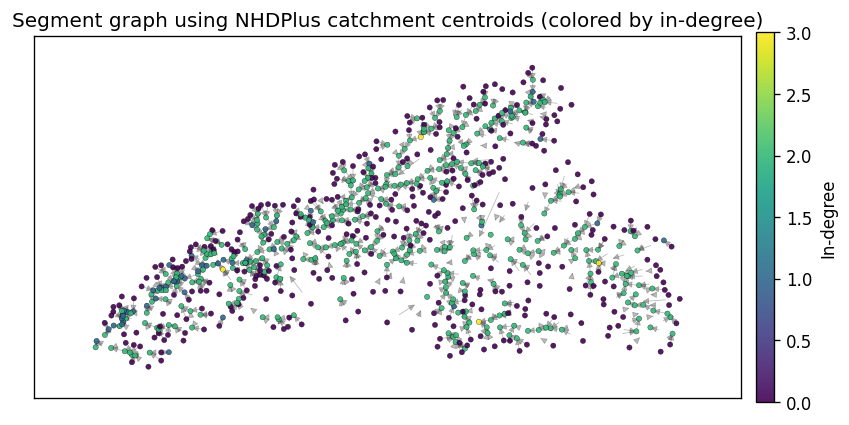

In [30]:
from pathlib import Path
import csv

# Paths mirroring the deprecated draw_static_graph.py defaults
CENTROID_SHP = DATA_ROOT / "data/orig/hja_study_area/NHDPlusCatchment_HJA_Centroid.shp"
ID_GRID_CSV = DATA_ROOT / "data/orig/hja_study_area/nhdplusid_gridcode_matchup.csv"

print("Centroid shapefile:", CENTROID_SHP)
print("NHDPlusID -> GridCode CSV:", ID_GRID_CSV)


def _load_gridcode_centroids(centroid_shp: Path) -> dict[int, tuple[float, float]]:
    """Read a centroid shapefile and build a mapping: GridCode -> (x, y).

    This mirrors the logic in deprecated/graph_builder/code/draw_static_graph.py
    and uses the `pyshp` package (imported as `shapefile`).
    """

    if not centroid_shp.exists():
        raise FileNotFoundError(f"Centroid shapefile not found: {centroid_shp}")

    try:
        import shapefile  # pyshp
    except Exception as exc:
        raise RuntimeError(
            "Geospatial layout requires the 'pyshp' package. Install with: pip install pyshp"
        ) from exc

    reader = shapefile.Reader(str(centroid_shp))
    fields = [f[0] for f in reader.fields[1:]]
    colnames = {name.lower(): name for name in fields}

    grid_field = None
    for cand in ("GridCode", "GRIDCODE", "gridcode", "NHDPlusC_3"):
        if cand in fields:
            grid_field = cand
            break
        if cand.lower() in colnames:
            grid_field = colnames[cand.lower()]
            break
    if grid_field is None:
        raise RuntimeError("Could not find a GridCode field in centroid shapefile attributes.")

    records = reader.records()
    shapes = reader.shapes()
    grid_to_xy: dict[int, tuple[float, float]] = {}
    for rec, shp in zip(records, shapes):
        rec_map = dict(zip(fields, rec))
        try:
            grid = int(rec_map[grid_field])
        except Exception:
            continue
        if not shp.points:
            continue
        x, y = shp.points[0]
        grid_to_xy[grid] = (float(x), float(y))
    return grid_to_xy


def _load_id_to_grid(csv_path: Path) -> dict[int, int]:
    """Load mapping from NHDPlusID (graph node id) to GridCode (centroid id)."""

    if not csv_path.exists():
        raise FileNotFoundError(f"ID->GridCode CSV not found: {csv_path}")
    id_to_grid: dict[int, int] = {}
    with csv_path.open("r", newline="") as fh:
        reader = csv.DictReader(fh)
        for row in reader:
            try:
                nid = int(row["NHDPlusID"])
                grid = int(row["GridCode"])
                id_to_grid[nid] = grid
            except Exception:
                continue
    return id_to_grid


def compute_geo_positions_from_centroids(
    graph: nx.DiGraph,
    centroid_shp: Path,
    id_grid_csv: Path,
    seed: int = 42,
) -> dict:
    """Compute node positions using geospatial centroids (NHDPlusID -> GridCode -> (x, y))."""

    id_to_grid = _load_id_to_grid(id_grid_csv)
    grid_to_xy = _load_gridcode_centroids(centroid_shp)

    pos: dict = {}
    fixed_nodes: list = []
    for node in graph.nodes():
        try:
            grid = id_to_grid.get(int(node))
        except Exception:
            grid = None
        if grid is None:
            continue
        coords = grid_to_xy.get(grid)
        if coords is None:
            continue
        pos[node] = np.asarray(coords, dtype=float)
        fixed_nodes.append(node)

    if len(pos) == 0:
        raise RuntimeError(
            "Failed to map any nodes to geospatial coordinates. "
            "Check that node IDs are NHDPlusID and geo data paths are correct."
        )

    # If some nodes are unmapped, place them with a spring layout while keeping
    # the geospatial ones fixed in place.
    if len(pos) < graph.number_of_nodes():
        pos = nx.spring_layout(graph, seed=seed, pos=pos, fixed=fixed_nodes)
    return pos


def plot_graph_geographic_centroids(graph: nx.DiGraph) -> plt.Figure:
    """Plot the graph using centroid-based geographic coordinates."""

    pos = compute_geo_positions_from_centroids(
        graph=graph,
        centroid_shp=CENTROID_SHP,
        id_grid_csv=ID_GRID_CSV,
        seed=42,
    )

    fig, ax = plt.subplots(figsize=(8, 8))
    nx.draw_networkx_edges(
        graph,
        pos,
        width=0.5,
        arrows=True,
        arrowstyle="-|>",
        arrowsize=8,
        alpha=0.4,
        edge_color="#555555",
        ax=ax,
    )

    # Color nodes by in-degree to show flow convergence
    nodes_with_pos = list(pos.keys())
    in_degrees = [graph.in_degree(nid) for nid in nodes_with_pos]
    nodes_coll = nx.draw_networkx_nodes(
        graph,
        pos,
        nodelist=nodes_with_pos,
        node_size=10,
        node_color=in_degrees,
        cmap=plt.cm.viridis,
        edgecolors="black",
        linewidths=0.2,
        alpha=0.9,
        ax=ax,
    )
    fig.colorbar(
        nodes_coll,
        ax=ax,
        label="In-degree",
        fraction=0.03,
        pad=0.02,
        shrink=0.5,
    )

    ax.set_title("Segment graph using NHDPlus catchment centroids (colored by in-degree)")
    ax.set_aspect("equal", adjustable="box")
    return fig


_ = plot_graph_geographic_centroids(segment_graph)

